<a href="https://colab.research.google.com/github/alunfes/1m-btc-data/blob/master/qiita47_DDPG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.表示用の前処理

In [ ]:
# 参考：https://qiita.com/ymd_h/items/c393797deb72e1779269
!apt update && apt install xvfb
!pip install gym-notebook-wrapper

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:6 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:8 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Ign:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:13 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64

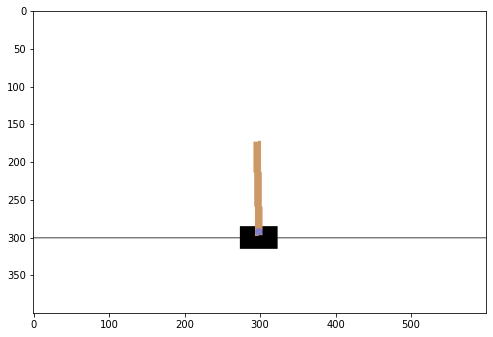

In [ ]:
# 確認用

import gnwrapper
import gym

env = gnwrapper.LoopAnimation(gym.make('CartPole-v1'))

o = env.reset()

for _ in range(100):
    o, r, d, i = env.step(env.action_space.sample())
    env.render()
    if d:
        env.reset()

env.close()
env.display()

# 1.共通コード

## 1-1. テスト用コード

In [ ]:
def testEnv(env, model):
  for episode in range(5):
    state = np.asarray(env.reset())
    env.render()
    done = False
    total_reward = 0
    step = 0
    while not done:
      action = model.sample_action(state)
      n_state, reward, done, _ = env.step(action)
      env.render()
      state = np.asarray(n_state)
      step += 1
      total_reward += reward
    print("{}, step: {}, reward: {}".format(episode, step, total_reward))

## 1-2. テスト用コード(表示用)


In [ ]:
import gnwrapper
def testRender(env, model):
  env = gnwrapper.LoopAnimation(env)
  state = np.asarray(env.reset())
  env.render()    # ゲームの描画
  done = False
  total_reward = 0
  step = 0
  while not done:
    action = model.sample_action(state)
    n_state, reward, done, _ = env.step(action)
    env.render()
    state = np.asarray(n_state)
    step += 1
    total_reward += reward
  print("step: {}, reward: {}".format(step, total_reward))
  env.display()

## 1-3. import

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt

from collections import deque
import random

# 2.DDPG/TD3(Pendulum-v0：連続行動空間)

## Actorモデル(SubClass API)

In [ ]:
class ActorModel(keras.Model):
    def __init__(self, action_space):
        super().__init__()

        self.noise_stdev = 0.2  # ノイズ用の標準偏差
        self.action_space = action_space

        # Envアクション用
        self.action_centor = (action_space.high + action_space.low)/2
        self.action_scale = action_space.high - self.action_centor

        # 各レイヤーを定義
        self.dense1 = keras.layers.Dense(32, activation="relu")
        self.dense2 = keras.layers.Dense(32, activation="relu")
        self.dense3 = keras.layers.Dense(32, activation="relu")
        self.actions = keras.layers.Dense(action_space.shape[0], activation="tanh")
        
        # optimizer
        self.optimizer = Adam(lr=0.003)

    # Forward pass
    def call(self, inputs, training=False):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        actions = self.actions(x)
        return actions

    # 状態を元にactionを算出
    def sample_action(self, state, training=False):
        actions = self(state.reshape((1,-1)))
        action = actions[0].numpy()

        if training:
            # 学習用
            # ノイズを混ぜる
            noise = np.random.normal(0, self.noise_stdev, size=self.action_space.shape)
            action = np.clip(action + noise, -1, 1)

            # 環境用のアクションと学習用のアクションを返す
            return (action * self.action_scale + self.action_centor), action
        else:
            # テスト用、環境に渡すアクションのみを返す
            return action * self.action_scale + self.action_centor


## Criticモデル(SubClass API)

In [ ]:
class CriticModel(keras.Model):
    def __init__(self):
        super().__init__()

        # 各レイヤーを定義
        self.dense1 = keras.layers.Dense(32, activation="relu")
        self.dense2 = keras.layers.Dense(32, activation="relu")
        self.dense3 = keras.layers.Dense(32, activation="relu")
        self.value1 = keras.layers.Dense(1, activation="linear")
        self.dense4 = keras.layers.Dense(32, activation="relu")
        self.dense5 = keras.layers.Dense(32, activation="relu")
        self.dense6 = keras.layers.Dense(32, activation="relu")
        self.value2 = keras.layers.Dense(1, activation="linear")

        # optimizer
        self.optimizer = Adam(lr=0.003)

    # Forward pass
    def call(self, states, actions, training=False):
        x = tf.concat([states, actions], axis=1)
        x1 = self.dense1(x)
        x1 = self.dense2(x1)
        x1 = self.dense3(x1)
        q1 = self.value1(x1)
        x2 = self.dense4(x)
        x2 = self.dense5(x2)
        x2 = self.dense6(x2)
        q2 = self.value2(x2)
        return q1, q2

## モデル更新のコード

In [ ]:
def update_model(
        actor_model, 
        target_actor_model, 
        critic_model, 
        target_critic_model, 
        experiences, 
        batch_size, 
        gamma,
        all_train_count,
        actor_update_interval,
        target_policy_noise_stddev,
        target_policy_clip_range,
    ):

    # ランダムに経験を取得してバッチを作成
    batchs = random.sample(experiences, batch_size)

    # Target Networkを用いて次の状態の価値を出す
    n_states = np.asarray([e["n_state"] for e in batchs])
    n_actions = target_actor_model(n_states)

    # Target Actionのノイズ
    clipped_noise = np.clip(np.random.normal(0, target_policy_noise_stddev, n_actions.shape), -target_policy_clip_range, target_policy_clip_range)
    n_actions = np.clip(n_actions + clipped_noise, -1, 1)

    # 2つのQ値から小さいほうを採用
    n_qvals1, n_qvals2 = target_critic_model(n_states, n_actions)
    n_qvals = [min(q1, q2) for q1, q2 in zip(n_qvals1.numpy(), n_qvals2.numpy())]

    # Qを計算 : reward if done else (reward + gamma * n_qval)
    q_vals = np.asarray([
        [reward] if done else [reward] + gamma * n_qval
        for reward, done, n_qval in zip(
            [e["reward"] for e in batchs],
            [e["done"] for e in batchs],
            n_qvals,
        )
    ])

    # データ整形
    states = np.asarray([e["state"] for e in batchs])
    actions = np.asarray([e["action"] for e in batchs])

    #--- Actorの学習
    # Actorの学習は少し減らす
    if all_train_count % actor_update_interval == 0:
        with tf.GradientTape() as tape:
            actor_actions = actor_model(states, training=True)
            q, _ = critic_model(states, actor_actions)
            actor_loss = -tf.reduce_mean(q)  # 最大化
        
        grads = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_model.optimizer.apply_gradients(zip(grads, actor_model.trainable_variables))
    else:
        actor_loss = 0

    #--- Criticの学習 MSEで学習
    with tf.GradientTape() as tape:
        q1, q2 = critic_model(states, actions, training=True)
        loss1 = tf.reduce_mean(tf.square(q_vals - q1))
        loss2 = tf.reduce_mean(tf.square(q_vals - q2))
        critic_loss = loss1 + loss2
    
    grads = tape.gradient(critic_loss, critic_model.trainable_variables)
    critic_model.optimizer.apply_gradients(zip(grads, critic_model.trainable_variables))

    return actor_loss, critic_loss

## Target Network 同期コード

In [ ]:
def update_target_model(actor_model, target_actor_model, critic_model, target_critic_model, soft_tau):

    target_actor_model.set_weights(
        (1 - soft_tau) * np.array(target_actor_model.get_weights(), dtype=object)
        + (soft_tau) * np.array(actor_model.get_weights(), dtype=object))

    target_critic_model.set_weights(
        (1 - soft_tau) * np.array(target_critic_model.get_weights(), dtype=object)
        + (soft_tau) * np.array(critic_model.get_weights(), dtype=object))


## 学習のメインコード(ハイパーパラメータ含む)

In [ ]:
def train_main():
    env = gym.make("Pendulum-v0")

    # ハイパーパラメータ
    buffer_size = 10000  # キューの最大容量
    warmup_size = 500    # 最低限キューに入れる数
    train_interval = 10  # 学習間隔
    batch_size = 32      # バッチサイズ
    gamma = 0.9          # 割引率
    soft_tau = 0.02      # Target network の近づく割合
    actor_update_interval = 2         # Actorの更新間隔
    target_policy_noise_stddev = 0.2  # Target policy ノイズの標準偏差
    target_policy_clip_range = 0.5    # Target policy ノイズのclip範囲

    # モデルの定義
    actor_model = ActorModel(env.action_space)
    target_actor_model = ActorModel(env.action_space)
    critic_model = CriticModel()
    target_critic_model = CriticModel()

    # モデルは一度伝搬させないと重みが作成されない
    dummy_state = np.random.normal(0, 0.1, size=(1,) + env.observation_space.shape)
    actor_model(dummy_state)
    target_actor_model(dummy_state)
    target_actor_model.set_weights(actor_model.get_weights())

    dummy_action  = np.random.normal(0, 0.1, size=(1,) + env.action_space.shape)
    critic_model(dummy_state, dummy_action)
    target_critic_model(dummy_state, dummy_action)
    target_critic_model.set_weights(critic_model.get_weights())

    # 収集する経験は上限を決め、古いものから削除する
    experiences = deque(maxlen=buffer_size)

    all_step_count = 0
    all_train_count = 0

    # 記録用
    history_rewards = []
    history_metrics = []
    history_metrics_y = []

    # 学習ループ
    for episode in range(500):
        state = np.asarray(env.reset())
        done = False
        total_reward = 0
        step = 0

        metrics_list = []

        # 1episode
        while not done:
            # アクションを決定
            env_action, action = actor_model.sample_action(state, True)

            # 1step進める
            n_state, reward, done, _ = env.step(env_action)
            n_state = np.asarray(n_state)
            step += 1
            total_reward += reward

            experiences.append({
                "state": state,
                "action": action,
                "reward": reward,
                "n_state": n_state,
                "done": done,
            })
            state = n_state
            
            if len(experiences) == warmup_size-1:
                print("train start")
              
            # warmup貯まったら train_interval 毎に学習する
            if len(experiences) >= warmup_size and all_step_count % train_interval == 0:
                # モデルの更新
                metrics = update_model(
                    actor_model, 
                    target_actor_model, 
                    critic_model, 
                    target_critic_model, 
                    experiences, 
                    batch_size, 
                    gamma,
                    all_train_count,
                    actor_update_interval,
                    target_policy_noise_stddev,
                    target_policy_clip_range,
                )
                # Soft-target
                update_target_model(
                    actor_model, 
                    target_actor_model, 
                    critic_model, 
                    target_critic_model, 
                    soft_tau
                )
                all_train_count += 1
                metrics_list.append(metrics)
            
            all_step_count += 1
        
        # 報酬
        history_rewards.append(total_reward)

        # メトリクス
        if len(metrics_list) > 0:
            history_metrics.append(np.mean(metrics_list, axis=0))  # 平均を保存
            history_metrics_y.append(episode)

        #--- print
        interval = 50
        if episode % interval == 0:
            print("{} (min,ave,max)reward {:.1f} {:.1f} {:.1f}".format(
                episode,
                min(history_rewards[-interval:]),
                np.mean(history_rewards[-interval:]),
                max(history_rewards[-interval:]),
            ))
    
    return actor_model, history_rewards, history_metrics, history_metrics_y

## 学習の実行

In [ ]:
model, history_rewards, history_metrics, history_metrics_y = train_main()

0 (min,ave,max)reward -1395.1 -1395.1 -1395.1
train start
50 (min,ave,max)reward -1744.0 -1273.6 -519.9
100 (min,ave,max)reward -1538.2 -692.9 -2.3
150 (min,ave,max)reward -1351.5 -320.2 -0.5
200 (min,ave,max)reward -703.7 -258.8 -0.5
250 (min,ave,max)reward -553.2 -217.1 -0.2
300 (min,ave,max)reward -1527.7 -369.2 -0.4
350 (min,ave,max)reward -917.4 -241.6 -1.3
400 (min,ave,max)reward -1531.7 -229.5 -0.6
450 (min,ave,max)reward -1351.1 -228.7 -0.6


## 学習過程のグラフ表示

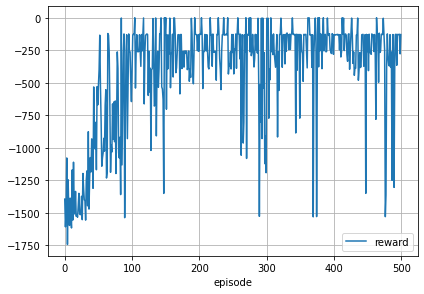

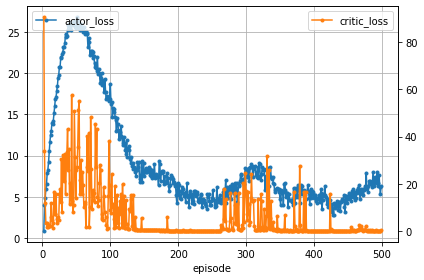

In [ ]:
plt.plot(history_rewards, label="reward")
plt.tight_layout()
plt.xlabel('episode')
plt.grid()
plt.legend()
plt.show()

fig, ax1 = plt.subplots()

ax1.set_xlabel('episode')
ax1.grid()
ax1.plot(history_metrics_y, [m[0] for m in history_metrics], color="C0", marker='.', label="actor_loss")
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(history_metrics_y, [m[1] for m in history_metrics], color="C1", marker='.', label="critic_loss")
ax2.legend(loc='upper right')

fig.tight_layout()  # レイアウトの設定
#plt.savefig('cartpole2.png') # 画像の保存
plt.show()

## テスト(5回)

In [ ]:
testEnv(gym.make("Pendulum-v0"), model)

0, step: 200, reward: -128.59149440220872
1, step: 200, reward: -128.65945531289174
2, step: 200, reward: -263.89323318272176
3, step: 200, reward: -271.7896497806277
4, step: 200, reward: -133.05162572733533


## テスト(描画)

step: 200, reward: -129.42759913638295


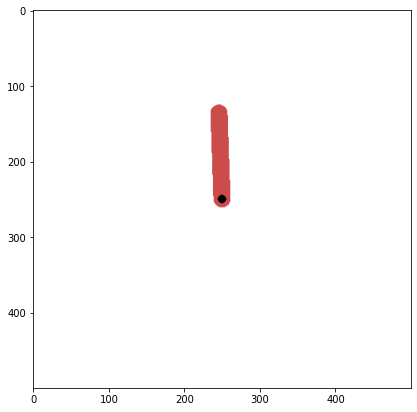

In [ ]:
testRender(gym.make("Pendulum-v0"), model)